In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.append('../..')

# Creature

In [2]:
from lamarck import Creature

In [3]:
genome = {
    'x': 10,
    'y': 'A',
    'z': (1, 2, 3)
}

In [4]:
creature = Creature(genome)

In [5]:
creature.id

-2732894652789882171

# Genome Creator

In [6]:
from lamarck.assistant import GenomeCreator

In [7]:
genome_creator = GenomeCreator()

In [8]:
genome_creator.add_gene_specs.numeric(name='x',
                                      min=0,
                                      max=10,
                                      progression='linear',
                                      domain='int')

genome_creator.add_gene_specs.categorical(name='y', domain=['A', 'B', 'C', 'D', 'E'])

genome_creator.add_gene_specs.vectorial(name='z', length=4, replace=False, domain=['i', 'j', 'k', 'l', 'm'])

In [9]:
genome_blueprint = genome_creator.get_genome_blueprint()

In [10]:
genome_blueprint

{'x': {'type': 'numeric',
  'domain': 'int',
  'ranges': {'min': 0, 'max': 10, 'progression': 'linear'}},
 'y': {'type': 'categorical', 'domain': ['A', 'B', 'C', 'D', 'E']},
 'z': {'type': 'vectorial',
  'domain': ['i', 'j', 'k', 'l', 'm'],
  'ranges': {'length': 4, 'replace': False}}}

# Population Creator

In [11]:
from lamarck.assistant import PopulationCreator

In [12]:
pop_creator = PopulationCreator(genome_blueprint)

In [13]:
popdet = pop_creator.create.det(8)
popdet

Population with 320 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [14]:
popdet.datasets.input.head()

,x,y,z
id,,,
3031482908558041379,0,A,"(i, j, k, l)"
6251823401527655697,0,A,"(i, l, k, m)"
3840016745127989809,0,A,"(j, k, i, l)"
4223112620767646059,0,A,"(j, m, k, l)"
2397758302742530432,0,A,"(k, l, i, j)"


In [15]:
poprand = pop_creator.create.rand(500)
poprand

Population with 479 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [16]:
poprand.datasets.input.head()

,x,y,z
id,,,
1759538036093661357,5,C,"(l, j, i, k)"
1120153781201280843,4,B,"(j, k, i, l)"
-5507276641304832881,1,D,"(j, l, m, i)"
-2848532857695145308,3,D,"(l, j, k, m)"
2475634850107127965,4,D,"(m, i, j, k)"


In [17]:
pop = popdet + poprand
pop

Population with 773 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [18]:
pop.datasets.input.head()

,x,y,z
id,,,
3031482908558041379,0,A,"(i, j, k, l)"
6251823401527655697,0,A,"(i, l, k, m)"
3840016745127989809,0,A,"(j, k, i, l)"
4223112620767646059,0,A,"(j, m, k, l)"
2397758302742530432,0,A,"(k, l, i, j)"


In [19]:
pop.define()

# Environment

In [20]:
from lamarck import Environment

In [21]:
import hashlib

def tuplehash(tuple_obj):
    encoded = ''.join(tuple_obj).encode()
    m = hashlib.md5()
    m.update(encoded)
    d = m.digest()
    return int.from_bytes(d, 'big')
    
    
def dummy_process(x, y, z):
    zval = (tuplehash(z) % 1000) / (x+1)**0.75
    yval = zval // ord(y) + tuplehash((y, y)) % 73
    return {
        'time': (x + 1) * abs(zval - yval) // 10,
        'profit': (abs(3*zval - 2*yval)**((int(x/10) + 1) % 9) // (tuplehash((y, y)) % 7 + 1)) % 10000 + (zval*yval) //10
    }

In [22]:
env = Environment()

In [23]:
env.config.set_process(dummy_process)

In [24]:
env.config.set_output_varibles('time', 'profit')

In [25]:
env.config

multi:   False
output_varibles:   ('time', 'profit')
process:   <function dummy_process at 0x7f76c1d28700>

### Simulate Creature

In [26]:
cr = pop[0]

In [27]:
env.simulate(cr)

{'time': 95.0, 'profit': 2154.0}

### Simulate Population

In [28]:
simpop = pop.copy()

In [29]:
env.simulate(simpop)

In [30]:
simpop.datasets.output.head()

,x,y,z,time,profit
id,,,,,
3031482908558041379,0,A,"(i, j, k, l)",95.0,2154.0
6251823401527655697,0,A,"(i, l, k, m)",62.0,1105.0
3840016745127989809,0,A,"(j, k, i, l)",56.0,930.0
4223112620767646059,0,A,"(j, m, k, l)",27.0,338.0
2397758302742530432,0,A,"(k, l, i, j)",45.0,715.0


### Simulate Population - Multi Thread

In [31]:
env.config.set_multi(True)

In [32]:
env.simulate(simpop)

In [33]:
simpop.datasets.output.head()

,x,y,z,time,profit
id,,,,,
3031482908558041379,0,A,"(i, j, k, l)",95.0,2154.0
6251823401527655697,0,A,"(i, l, k, m)",62.0,1105.0
3840016745127989809,0,A,"(j, k, i, l)",56.0,930.0
4223112620767646059,0,A,"(j, m, k, l)",27.0,338.0
2397758302742530432,0,A,"(k, l, i, j)",45.0,715.0


# Fitness

### 1. Single Objective

In [34]:
single_objective_pop = simpop.copy()
single_objective_pop.apply_fitness.single_objective(output='time', objective='min')

In [35]:
single_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria
id,,,,,,
2059556440789537027,1,D,"(l, k, m, j)",0.0,28.0,0.0
-6722489819240181410,2,A,"(m, l, i, j)",0.0,1.0,0.0
2039874956744511581,4,E,"(i, k, j, l)",0.0,220.0,0.0
-214453022490344539,2,D,"(l, j, m, k)",0.0,32.0,0.0
-2557345861107735535,6,A,"(j, l, i, m)",0.0,1.0,0.0


### 2. Multi Objective - Ranked

In [36]:
ranked_objective_pop = simpop.copy()
ranked_objective_pop.apply_fitness.multi_objective.ranked(priorities=['time', 'profit'], objectives=['min', 'max'])

In [37]:
ranked_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria0,criteria1
id,,,,,,,
2039874956744511581,4,E,"(i, k, j, l)",0.0,220.0,0.0,220.0
-214453022490344539,2,D,"(l, j, m, k)",0.0,32.0,0.0,32.0
2059556440789537027,1,D,"(l, k, m, j)",0.0,28.0,0.0,28.0
-2557345861107735535,6,A,"(j, l, i, m)",0.0,1.0,0.0,1.0
-6722489819240181410,2,A,"(m, l, i, j)",0.0,1.0,0.0,1.0


### 3. Multi Objective - Pareto

In [38]:
pareto_objective_pop = simpop.copy()
pareto_objective_pop.apply_fitness.multi_objective.pareto(outputs=['time', 'profit'], objectives=['min', 'max'])

In [39]:
pareto_objective_pop.datasets.fitness.head()

,x,y,z,time,profit,criteria0,criteria1,front,crowd
id,,,,,,,,,
-3709377954076378354,10,E,"(i, l, k, m)",64.0,10444.0,-0.078279,6.751078,1,inf
-2557345861107735535,6,A,"(j, l, i, m)",0.0,1.0,-1.530879,-0.677934,1,inf
3528809817317481984,10,B,"(l, m, i, j)",13.0,3417.0,-1.235819,1.752163,1,4.739160
6007242308276684661,10,B,"(l, i, k, m)",22.0,7089.0,-1.031548,4.364375,1,4.231874
-7010074918900690879,10,B,"(j, m, k, l)",26.0,8951.0,-0.940760,5.688977,1,3.339971


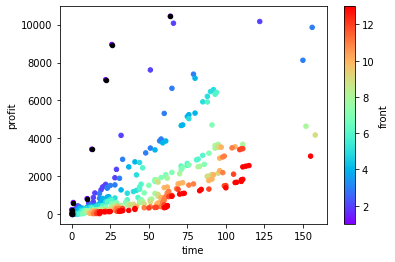

In [40]:
ax = pareto_objective_pop.plot.fronts('time', 'profit', 1)

# Selection

In [41]:
selected_pop = pareto_objective_pop.select()
selected_pop

Population with 386 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [42]:
selected_pop.datasets.fitness

,x,y,z,time,profit,criteria0,criteria1,front,crowd
id,,,,,,,,,
-3709377954076378354,10,E,"(i, l, k, m)",64.0,10444.0,-0.078279,6.751078,1,inf
-2557345861107735535,6,A,"(j, l, i, m)",0.0,1.0,-1.530879,-0.677934,1,inf
3528809817317481984,10,B,"(l, m, i, j)",13.0,3417.0,-1.235819,1.752163,1,4.739160
6007242308276684661,10,B,"(l, i, k, m)",22.0,7089.0,-1.031548,4.364375,1,4.231874
-7010074918900690879,10,B,"(j, m, k, l)",26.0,8951.0,-0.940760,5.688977,1,3.339971
...,...,...,...,...,...,...,...,...,...
-6638583988351599717,5,C,"(j, m, k, l)",33.0,168.0,-0.781882,-0.559133,13,0.131980
-9154516082064337167,5,D,"(l, m, i, j)",21.0,111.0,-1.054244,-0.599682,13,0.122021
8168757904882472624,5,D,"(m, l, k, i)",24.0,121.0,-0.986154,-0.592568,13,0.102881


# Repopulate

In [43]:
newpop = selected_pop.copy()
newpop

Population with 386 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [44]:
newpop.datasets.fitness

,x,y,z,time,profit,criteria0,criteria1,front,crowd
id,,,,,,,,,
-3709377954076378354,10,E,"(i, l, k, m)",64.0,10444.0,-0.078279,6.751078,1,inf
-2557345861107735535,6,A,"(j, l, i, m)",0.0,1.0,-1.530879,-0.677934,1,inf
3528809817317481984,10,B,"(l, m, i, j)",13.0,3417.0,-1.235819,1.752163,1,4.739160
6007242308276684661,10,B,"(l, i, k, m)",22.0,7089.0,-1.031548,4.364375,1,4.231874
-7010074918900690879,10,B,"(j, m, k, l)",26.0,8951.0,-0.940760,5.688977,1,3.339971
...,...,...,...,...,...,...,...,...,...
-6638583988351599717,5,C,"(j, m, k, l)",33.0,168.0,-0.781882,-0.559133,13,0.131980
-9154516082064337167,5,D,"(l, m, i, j)",21.0,111.0,-1.054244,-0.599682,13,0.122021
8168757904882472624,5,D,"(m, l, k, i)",24.0,121.0,-0.986154,-0.592568,13,0.102881


In [45]:
newpop.reproduce.tournament(n_children=len(newpop)/2)

In [46]:
newpop.reproduce.elitism()

Exception ignored in: <generator object generate_elite_parent_pair at 0x7f76bcfb70b0>
Traceback (most recent call last):
  File "<ipython-input-46-f056f8818bf1>", line 1, in <module>
RuntimeError: generator ignored GeneratorExit


In [47]:
newpop

Population with 773 Creatures with genes x (numeric), y (categorical), z (vectorial).
        

In [48]:
env.simulate(newpop)

In [49]:
newpop.apply_fitness.multi_objective.pareto(outputs=['time', 'profit'], objectives=['min', 'max'])

In [50]:
newpop.datasets.fitness

,x,y,z,time,profit,criteria0,criteria1,front,crowd
id,,,,,,,,,
-2557345861107735535,6,A,"(j, l, i, m)",0.0,1.0,-1.312529,-0.774208,1,inf
7547552849748484800,10,B,"(l, m, k, i)",0.0,429.0,-1.312529,-0.568228,1,inf
9201215717713139753,10,E,"(j, k, i, m)",97.0,10471.0,1.160141,4.264615,1,inf
3528809817317481984,10,B,"(l, m, i, j)",13.0,3417.0,-0.981140,0.869786,1,2.745388
6007242308276684661,10,B,"(l, i, k, m)",22.0,7089.0,-0.751717,2.636984,1,2.267556
...,...,...,...,...,...,...,...,...,...
-9142143899594030840,2,A,"(m, i, j, k)",12.0,36.0,-1.006632,-0.757364,10,0.000481
-6211984597322468346,4,A,"(j, i, m, l)",15.0,28.0,-0.930157,-0.761214,10,0.000481
-1117568345671185240,2,C,"(l, k, i, j)",29.0,274.0,-0.573277,-0.642824,10,0.000481


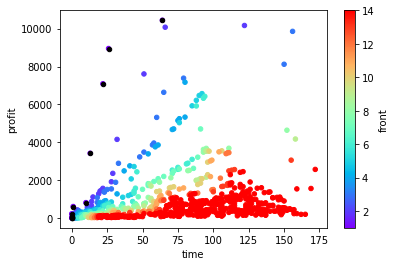

In [51]:
ax = pareto_objective_pop.plot.fronts('time', 'profit', 1, show_worst=True)

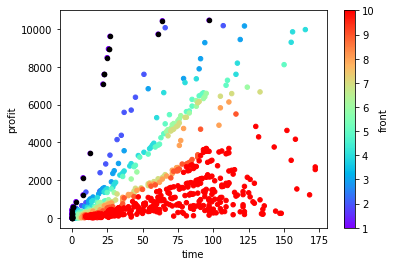

In [52]:
ax = newpop.plot.fronts('time', 'profit', 1, show_worst=True)

## Mutation

# Mini process example

In [53]:
from tqdm import tqdm

In [55]:
# population
pop_creator = PopulationCreator(genome_blueprint)
pop = pop_creator.create.det(7) + pop_creator.create.rand(500)
pop.define()

#environment
env = Environment()
env.config.set_process(dummy_process)
env.config.set_output_varibles('time', 'profit')

# iterarions
n_generations = 20
pbar = tqdm(range(n_generations))
profit = 0
for _ in pbar:
    pbar.set_description(f'[mean profit: {profit}] Simulating...')
    env.simulate(pop)
    profit = round(pop.datasets.output['profit'].mean(), 2)
    pbar.set_description(f'[mean profit: {profit}] Applying Fitness Criteria...')
    pop.apply_fitness.single_objective('profit', objective='max')
    pbar.set_description(f'[mean profit: {profit}] Selecting...')
    pop = pop.select()
    pbar.set_description(f'[mean profit: {profit}] Generating Offspring...')
    pop.reproduce.tournament(n_dispute=2)

[mean profit: 3911.49] Generating Offspring...: 100%|██████████| 20/20 [05:13<00:00, 15.68s/it]     


<AxesSubplot:xlabel='generation', ylabel='profit'>

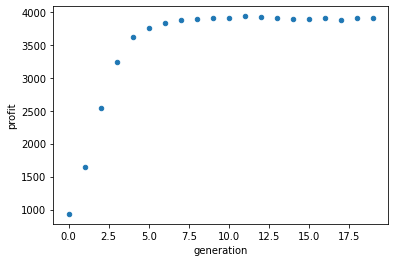

In [60]:
pop.plot.history('profit', 'mean')